# GANs Monet 'I’m Something of a Painter Myself' Kaggle Mini-Project
**GitHub Repository**: https://github.com/ilichenko/DTSA-5511

Useful guide on how to install TensorFlow in Jupyter Notebook: https://how.dev/answers/how-to-install-tensorflow-in-jupyter-notebook

## 1. Introduction
### 1.1. Problem Statement
In this study, we explore the use of Cycle-Consistent Generative Adversarial Networks (CycleGANs) for unpaired image-to-image translation. To begin with, we need to transform real-world photographs into paintings that imitate the unique visual style of Claude Monet. Furher, we need achieve convincing artistic style transfer without needing paired datasets, relying solely on two independent collections: Monet paintings and real photos.

### 1.2. Study Objective
The goal of this project is to design and implement a CycleGAN models based on ResNet-based and U-Net-style generators in TensorFlow that learns bidirectional mappings between two visual domains:
- **Monet to Photo**: Convert Monet-style paintings into realistic photo-like images.
- **Photo to Monet**: Stylize real photos to reflect the impressionist characteristics of Monet’s work.

Hence, if we turn a photo into a Monet-style painting and then back into a photo, we aim to get the same original photo and vice versa, which would confirm the cycle-consistency.

### 1.3. Dataset Overview
The dataset contains the following 2 domains: 
- **monet_jpg**: (~1.5k Monet paintings),
- **photo_jpg**: (~6k real photos)
- Format: JPG, 256x256 RGB images

## 2. Exploratory Data Analysis (EDA) and Data Preprocessing

The following code installs the required libraries and imports the data:

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from tensorflow.keras import layers

In [2]:
MONET_PATH = "./monet_jpg"
PHOTO_PATH = "./photo_jpg"

AUTOTUNE = tf.data.AUTOTUNE
IMG_HEIGHT = 256
IMG_WIDTH = 256

EPOCHS = 20
STEPS_PER_EPOCH = 100

SUBMISSION_SAMPLE_SIZE = 7777
SUBMISSION_ZIP_PATH = 'images.zip'

Next, we define a preprocessing pipeline to decode each image, resize them to 256x256, and finally normalize them between -1 and 1. Then, we build input pipelines for training using the following components:
- `shuffle(1000)` ensures randomness randomly shuffling up to 1000 items at a time while iterating over the dataset,
- `cache()` speeds up the training process,
- `repeat()` repeats the dataset infinitely, preventing it from running out after one epoch,
- `prefetch()` overlaps preprocessing and model execution.

In [4]:
monet_files = tf.data.Dataset.list_files(str(MONET_PATH + '/*.jpg'))
photo_files = tf.data.Dataset.list_files(str(PHOTO_PATH + '/*.jpg'))

@tf.function
def decode_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img / 127.5) - 1
    return img

def get_dataset(file_paths, batch_size=1):
    return file_paths.map(decode_img, num_parallel_calls=AUTOTUNE) \
                     .shuffle(1000) \
                     .batch(batch_size) \
                     .cache() \
                     .repeat() \
                     .prefetch(AUTOTUNE)

def get_dataset_sample(file_paths, batch_size=1):
    return file_paths.map(decode_img) \
                     .take(5) \
                     .cache() \
                     .repeat()

monet_ds = get_dataset(monet_files)
photo_ds = get_dataset(photo_files)

monet_ds_sample = get_dataset_sample(monet_files)
photo_ds_sample = get_dataset_sample(photo_files)

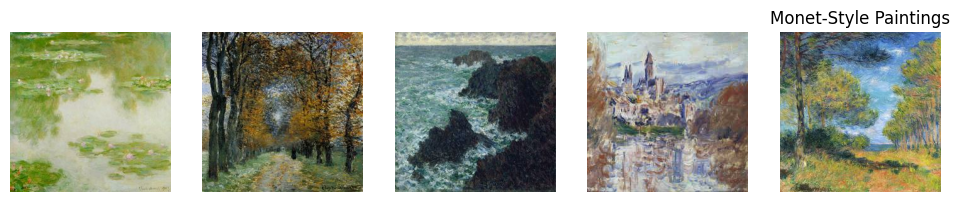

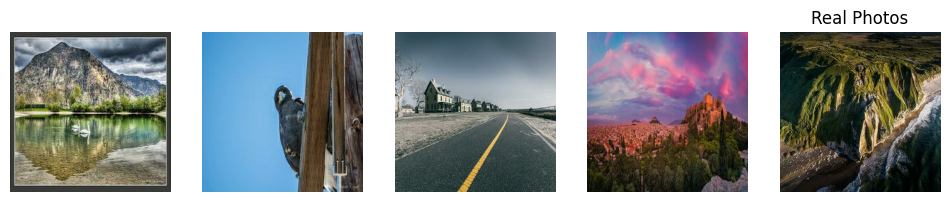

In [5]:
import matplotlib.pyplot as plt

def show_samples(dataset, title):
    plt.figure(figsize=(12, 4))
    for i, image in enumerate(dataset):
        if i >= 5:
            break
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow((image + 1) / 2)
        plt.axis("off")
    plt.title(title)
    plt.show()

show_samples(monet_ds_sample, "Monet-Style Paintings")
show_samples(photo_ds_sample, "Real Photos")

To summarize, we see that the structure of both datasets is clean and well-defined. Moreover, no corrupt or malformed images were encountered during the decoding, thus no additional data cleaning was required. Finally, as we have class imbalance, we handled this issue with balanced batch sampling.

## 3. Model Building

After setting up the data pipeline, we start building the CycleGAN models. The architecture consists of:

- **OPTION 1: ResNet-based Generator**:

    - **Input layer** with a **7x7 Conv2D** layer to capture broad image features,

    - **Downsampling layers** with stride=*2* progressively reduce spatial dimensions (*H×W → H/2×W/2 → H/4×W/4*) while increasing filter depth (*64 → 128 → 256*). This allows the model to learn more abstract representations,

    - **Bottleneck**: *9* ResNet blocks blocks help the generator learn complex transformations while preserving important image details through skip connections.
 
    - **Upsampling layers**: **Conv2DTranspose layers** gradually restore spatial resolution, ending with a **7x7 Conv2D** layer with `tanh` activation to output images normalized between -1 and 1.
 
- **OPTION 2: U-Net-style Generator**:

    - **Input layer** with a **3×3 Conv2D** layer to encode low-level texture and edge features.

    - **Downsampling layers** with stride=*2* progressively reduce the spatial resolution (*H×W → H/2×W/2 → H/4×W/4 → ...*) while increasing the number of filters step-by-step (*64 → 128 → 256 → 512*). Each block uses *BatchNorm* and *LeakyReLU*, enabling stable encoding.

    - **Bottleneck** uses **Conv2D** with maximum filter depth *512*, preparing for upsampling.

    - **Upsampling layers** apply **Conv2DTranspose** layers to restore resolution step-by-step (*H/8×W/8 → H/4×W/4 → H/2×W/2 → H×W*). Each upsampling step includes a *skip connection* from the corresponding downsampling layer (U-Net symmetry). Concatenation across skip paths preserves spatial precision and texture alignment.

    - **Output layer** finishes with a **3×3 Conv2D** layer and `tanh` activation, outputting the final image in the range *[-1, 1]*.



- **Discriminator**: employs a **PatchGAN** architecture using stacked **Conv2D** layers (*64 → 128 → 256* filters) with **LeakyReLU** activations and **BatchNormalization** to distinguish real from generated images on the patch level. The final **Conv2D** outputs a single-channel authenticity map.

- **Optimizers**: all models use **Adam optimizer** with learning rate *2e-4* and $\beta_1$=*0.5*, which stabilizes GAN training.

- **Loss functions**:

    - binary cross-entropy is responsible for the adversarial training.
      
    - **cycle consistency loss** enforces that translations map back correctly, i.e. `x → G(x) → F(G(x)) ≈ x`.
      
    - **identity loss** helps preserve color and style between domains.
      
    - Both, **cycle consistency loss** and **identity loss** use the weight of *12*.

- **Checkpoints**: the state of all generators, discriminators, and their optimizers which ensure we can resume training or restore best-performing models.

In [6]:
# ResNet Blocks
def resnet_block(x, filters):
    init = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.add([init, x])

# Selected Generator: ResNet-based
def build_generator():
    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Downsample
    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)

    # Bottleneck
    for _ in range(9):
        x = resnet_block(x, 256)

    # Upsample
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x)

# Alternative Generator: U-Net-style encoder-decoder
def build_unet_generator():
    inputs = tf.keras.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Encoder
    e1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    e1 = layers.LeakyReLU()(e1)

    e2 = layers.Conv2D(128, 4, strides=2, padding='same')(e1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.LeakyReLU()(e2)

    e3 = layers.Conv2D(256, 4, strides=2, padding='same')(e2)
    e3 = layers.BatchNormalization()(e3)
    e3 = layers.LeakyReLU()(e3)

    # Bottleneck
    bn = layers.Conv2D(512, 4, strides=2, padding='same')(e3)
    bn = layers.Activation('relu')(bn)

    # Decoder
    d1 = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(bn)
    d1 = layers.BatchNormalization()(d1)
    d1 = layers.Activation('relu')(d1)
    d1 = layers.Concatenate()([d1, e3])

    d2 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.Activation('relu')(d2)
    d2 = layers.Concatenate()([d2, e2])

    d3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(d2)
    d3 = layers.BatchNormalization()(d3)
    d3 = layers.Activation('relu')(d3)
    d3 = layers.Concatenate()([d3, e1])

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(d3)

    return tf.keras.Model(inputs, outputs)


# Discriminator
def build_discriminator():
    initializer = tf.random_normal_initializer(0, 0.02)
    inp = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='input_image')

    x = layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inp)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)

    return tf.keras.Model(inputs=inp, outputs=x)

gen_G = build_generator()
### gen_G = build_unet_generator
gen_F = build_generator()
### gen_F = build_unet_generator
disc_X = build_discriminator()

# Optimizers
gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define checkpoint
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    gen_G=gen_G, 
    gen_F=gen_F, 
    disc_X=disc_X, 
    gen_G_optimizer=gen_G_optimizer, 
    gen_F_optimizer=gen_F_optimizer, 
    disc_X_optimizer=disc_X_optimizer, 
    disc_Y_optimizer=disc_Y_optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Loss functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 12 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 12 * 0.5 * loss

## 4. Model Training

In the next step, we train our model on 20 epochs:

In [7]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        fake_y = gen_G(real_x, training=True)
        cycled_x = gen_F(fake_y, training=True)

        fake_x = gen_F(real_y, training=True)
        cycled_y = gen_G(fake_x, training=True)

        same_x = gen_F(real_x, training=True)
        same_y = gen_G(real_y, training=True)

        disc_real_x = disc_X(real_x, training=True)
        disc_fake_x = disc_X(fake_x, training=True)

        gen_G_loss = generator_loss(disc_X(fake_y, training=True))
        gen_F_loss = generator_loss(disc_X(fake_x, training=True))

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_gen_G_loss = gen_G_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_F_loss = gen_F_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)

    gradients_of_gen_G = tape.gradient(total_gen_G_loss, gen_G.trainable_variables)
    gradients_of_gen_F = tape.gradient(total_gen_F_loss, gen_F.trainable_variables)

    gradients_of_disc_X = tape.gradient(disc_X_loss, disc_X.trainable_variables)

    gen_G_optimizer.apply_gradients(zip(gradients_of_gen_G, gen_G.trainable_variables))
    gen_F_optimizer.apply_gradients(zip(gradients_of_gen_F, gen_F.trainable_variables))
    disc_X_optimizer.apply_gradients(zip(gradients_of_disc_X, disc_X.trainable_variables))

In [15]:
monet_iter = iter(monet_ds)
photo_iter = iter(photo_ds)

for epoch in range(EPOCHS):
    print(f'Running Epoch {epoch+1}/{EPOCHS}')
    for step in range(STEPS_PER_EPOCH):
        image_x = next(photo_iter)
        image_y = next(monet_iter)
        train_step(image_x, image_y)

Running Epoch 1/20
Running Epoch 2/20
Running Epoch 3/20
Running Epoch 4/20
Running Epoch 5/20
Running Epoch 6/20
Running Epoch 7/20
Running Epoch 8/20
Running Epoch 9/20
Running Epoch 10/20
Running Epoch 11/20
Running Epoch 12/20
Running Epoch 13/20
Running Epoch 14/20
Running Epoch 15/20
Running Epoch 16/20
Running Epoch 17/20
Running Epoch 18/20
Running Epoch 19/20
Running Epoch 20/20


## 6. Model Evaluation and Hyperparameter Tuning

Both architectures were tested under the same training conditions using the same dataset and loss functions. The U-Net generator performed very well, especially in preserving edge-level details. However, the ResNet-based generator consistently delivered results that were stylistically stronger and globally consistent - especially in the transfer of texture and brush strokes.

The skip-construction in U-Net proved useful for semantic consistency, but sometimes resulted in overly literal mappings, preventing effective abstraction of stylistic elements. In contrast, the ResNet-based generator struck a better balance between preserving content and conveying Monet's artistic style. Based on this qualitative comparison, the ResNet-based generator was selected as the final model.

All hyperparameters for training, including learning rate, optimizer settings, batch size, and loss weights, were chosen based on previous experiments and iterations of internal tuning. These settings consistently resulted in stable learning behavior and good visual quality in all trials. Thus, the hyperparameters from the previous sections are to be considered final.

Finally, we visualize the results of the model based on the chosen ResNet architecture and on the selected hyperparameters:

2025-06-19 15:56:05.057897: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


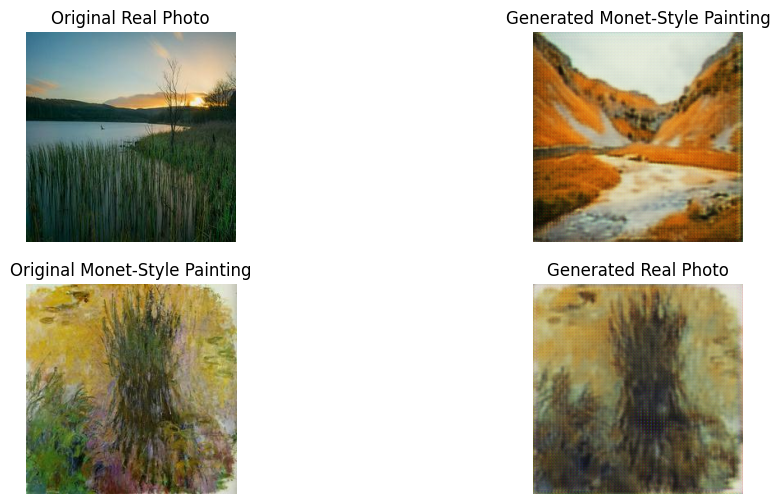

In [24]:
sample_monet = next(iter(monet_ds))
fake_monet = gen_F(sample_photo, training=False)

sample_photo = next(iter(photo_ds))
fake_photo = gen_G(sample_monet, training=False)

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.title("Original Real Photo")
plt.imshow((sample_photo[0] + 1) / 2)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Generated Monet-Style Painting")
plt.imshow((fake_monet[0] + 1) / 2)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Original Monet-Style Painting")
plt.imshow((sample_monet[0] + 1) / 2)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Generated Real Photo")
plt.imshow((fake_photo[0] + 1) / 2)
plt.axis('off')

plt.show()

## 8. Generating Submission File

In [ ]:
import zipfile
import io
from PIL import Image

submission_ds = monet_ds.take(SUBMISSION_SAMPLE_SIZE)

with zipfile.ZipFile(SUBMISSION_ZIP_PATH, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    for i, monet_image in enumerate(submission_ds):
        fake_photo = gen_F(monet_image, training=False)[0]
        fake_photo = ((fake_photo + 1.0) * 127.5).numpy().astype('uint8')

        img_buffer = io.BytesIO()
        img = Image.fromarray(fake_photo)
        img.save(img_buffer, format='JPEG')
        img_buffer.seek(0)

## 9. Conclusion

In this study, we designed and trained two CycleGAN architectures for the Monet-to-Photo image translation task: one based on ResNet blocks and the other using a U-Net-style encoder-decoder. Both used a sequential adversarial scheme with PatchGAN discriminators and had the same training configuration. From the evaluation results, we found that the ResNet-based generator produced more consistent, stylistically coherent translations, especially in terms of preserving content structure and mimicking artistic strokes.

In addition, the current configuration showed no need for further hyperparameter tuning, but this could be investigated in future experiments:
- reducing the number of ResNet blocks to speed up output,
- training on higher resolution images to improve photorealism, and
- applying perceptual or style loss to ensure artistic consistency.

In the context of this project, the main goal of achieving unpaired artistically realistic translation was successfully achieved, and the chosen architecture proved to be efficient.

## 10. References

- Geena Kim. DTSA 5511 Introduction to Deep Learning
- Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros. Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks.
- Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. Deep Residual Learning for Image Recognition.
- Edgar Schonfeld, Bernt Schiele, Anna Khoreva. A U-Net Based Discriminator for Generative Adversarial Networks.